### Multiple models using  MultiOutputClassifier

1. xgboost is the base model
2. CV with 5 samples/ not folds
3. Importances from CV 
4. Var reduction


In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.multioutput import MultiOutputClassifier
# from sklearn.model_selection import StratifiedKFold
# from sklearn.pipeline import Pipeline

In [2]:
SEED = 42
np.random.seed(SEED)

In [3]:
def PreProcessX(df):
    '''
    Preprocessing for independent  vars
    encode categoricals
    
    returns processed df,
    '''
    df['cp_dose'] = (df['cp_dose'] == 'D1').astype(int)
    df['cp_type'] = (df['cp_type'] == 'trt_cp').astype(int)
    
    return df

In [4]:
xAll = pd.read_csv('../Data/train_features.csv')
yAll = pd.read_csv('../Data/train_targets_scored.csv')

xAll = PreProcessX(xAll)

idList=['sig_id']
# xAll=xAll.drop(idList,axis=1)
# yAll=yAll.drop(idList,axis=1)

trainIds= xAll['sig_id'].sample(frac=0.7,random_state=SEED)
xTrain = xAll[xAll['sig_id'].isin(trainIds)]
yTrain = yAll[yAll['sig_id'].isin(trainIds)]
xValid = xAll[~xAll['sig_id'].isin(trainIds)]
yValid = yAll[~yAll['sig_id'].isin(trainIds)]





In [14]:
# classifier = MultiOutputClassifier(XGBClassifier(tree_method='gpu_hist',random_state=SEED))

# clf = Pipeline([('classify', classifier)])

# params = {'classify__estimator__colsample_bytree': 0.3,
#           'classify__estimator__gamma': 1,
#           'classify__estimator__learning_rate': 0.07,
#           'classify__estimator__max_depth': 6,
#           'classify__estimator__min_child_weight': 15,
#           'classify__estimator__max_delta_step': 1,
#           'classify__estimator__n_estimators': 800,
#           'classify__estimator__grow_policy': 'lossguide',
#           'classify__estimator__max_leaves': 24
#          }

# _ = clf.set_params(**params)

In [18]:
#%time multiModels= clf.fit(xTrain, yTrain)

CPU times: user 11min 41s, sys: 9.33 s, total: 11min 50s
Wall time: 11min 52s


In [5]:
NumRows =xTrain.shape[0]


params = {
    'objective':'binary:logistic',
    #'num_class':2,
    'max_depth' : 10, # for gpu hist
    'eta' : 0.05,
    'colsample_bytree' : 0.2,
    'min_child_weight' : int(NumRows*0.001),
    'gamma': 1,
    'tree_method':'gpu_hist',
    'grow_policy': 'lossguide',
    'max_leaves': 32, ## to constraint tree to be shallower
    'n_estimators': 900,
    'max_delta_step':1
    
}


xgMod = XGBClassifier(**params,random_state=SEED)


##### single model for setup
Parameters were changed for CV

In [7]:

%time  classifier = MultiOutputClassifier(xgMod).fit(xTrain, yTrain)

CPU times: user 12min 42s, sys: 9.39 s, total: 12min 51s
Wall time: 12min 52s


In [8]:
##diff model
trainPreds = classifier.predict_proba(xTrain)
trainPreds = np.array(trainPreds)[:,:,1].T
trainLoss = log_loss(np.ravel(yTrain), np.ravel(trainPreds))

validPreds = classifier.predict_proba(xValid)
validPreds = np.array(validPreds)[:,:,1].T
valLoss = log_loss(np.ravel(yValid), np.ravel(validPreds))
print(f'train loss {trainLoss} valid loss{valLoss}')

train loss 0.0108962807635367 valid loss0.01722624312747751


Feature importances from 5 models

https://stats.stackexchange.com/questions/162162/relative-variable-importance-for-boosting

In [8]:
%%time

validLosses = []
validPreds = []
featImp = []
for i in range(5):
    
    trainIds= xAll['sig_id'].sample(frac=0.7,random_state=(SEED +100*i + 10*i +i ))
    xTrain = xAll[xAll['sig_id'].isin(trainIds)]
    yTrain = yAll[yAll['sig_id'].isin(trainIds)]
    xValid = xAll[~xAll['sig_id'].isin(trainIds)]
    yValid = yAll[~yAll['sig_id'].isin(trainIds)]
 
    xTrain=xTrain.drop(idList,axis=1)
    xValid=xValid.drop(idList,axis=1)
    yTrain=yTrain.drop(idList,axis=1)
    yValid=yValid.drop(idList,axis=1)
                                    
                                    
    #fit model
    clf = MultiOutputClassifier(xgMod).fit(xTrain, yTrain)
    #get loss
    validPredsIn = clf.predict_proba(xValid)
    validPredsIn = np.array(validPredsIn)[:,:,1].T
    validPreds.append(validPredsIn)
    valLoss = log_loss(np.ravel(yValid), np.ravel(validPredsIn))
    validLosses.append(valLoss)
    #get importances
    InnerImp = [] 
    #multioutput importances
    for model in clf.estimators_:
        InnerImp.append(model.feature_importances_)
    featImp.append(np.nanmean(InnerImp, axis=0) )   
        
validLosses

/home/taran/depot/Projects/kaggleDev/venv/lib/python3.6/site-packages/xgboost/sklearn.py:695: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/taran/depot/Projects/kaggleDev/venv/lib/python3.6/site-packages/xgboost/sklearn.py:695: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/taran/depot/Projects/kaggleDev/venv/lib/python3.6/site-packages/xgboost/sklearn.py:695: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/taran/depot/Projects/kaggleDev/venv/lib/python3.6/site-packages/xgboost/sklearn.py:695: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/taran/depot/Projects/kaggleDev/venv/lib/python3.6/site-packages/xgboost/sklearn.py:695: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()


CPU times: user 1h 6min 52s, sys: 1min 8s, total: 1h 8min 1s
Wall time: 1h 4min 41s


[0.016818835437180883,
 0.017034743542869636,
 0.016899042059087096,
 0.016770016914106314,
 0.016851989914719055]

In [11]:
imp = InnerImp[0]/5

In [12]:
for i in range(1,5):
    imp += InnerImp[i]/5

In [14]:
imp = pd.DataFrame({'Imp': imp}, index=xTrain.columns).sort_values(by='Imp', ascending=False)
imp = imp.reset_index()

imp['CummProp'] = imp['Imp'].cumsum()
imp.head(10)

,index,Imp,CummProp
0,g-280,0.027026,0.027026
1,g-140,0.016387,0.043413
2,g-202,0.016236,0.059649
3,g-659,0.016018,0.075667
4,c-63,0.015875,0.091542
5,g-573,0.015630,0.107171
6,g-386,0.015235,0.122406
7,g-653,0.014255,0.136661
8,g-61,0.014054,0.150715
9,c-98,0.013339,0.164054


In [15]:
imp.to_csv('../dumps/VarImp_xgboostAllCv.csv')

In [30]:
imp[imp['CummProp'] <= 0.90]

,index,Imp,CummProp
0,g-280,0.027026,0.027026
1,g-140,0.016387,0.043413
2,g-202,0.016236,0.059649
3,g-659,0.016018,0.075667
4,c-63,0.015875,0.091542
...,...,...,...
491,g-273,0.000440,0.897932
492,g-295,0.000438,0.898371
493,g-366,0.000438,0.898809
494,g-760,0.000437,0.899246


496 variables contribute 90

Single model top 90% cummulative vars

In [32]:
vars_90 = imp[imp['CummProp'] <= 0.90]['index'].values

In [14]:
i=0## will correspond to first model in the cv
trainIds= xAll['sig_id'].sample(frac=0.7,random_state=(SEED +100*i + 10*i +i ))
xTrain = xAll[xAll['sig_id'].isin(trainIds)]
yTrain = yAll[yAll['sig_id'].isin(trainIds)]
xValid = xAll[~xAll['sig_id'].isin(trainIds)]
yValid = yAll[~yAll['sig_id'].isin(trainIds)]
 
xTrain=xTrain.drop(idList,axis=1)
xValid=xValid.drop(idList,axis=1)
yTrain=yTrain.drop(idList,axis=1)
yValid=yValid.drop(idList,axis=1)
                                    


In [33]:
                                    
#fit model
clf = MultiOutputClassifier(xgMod).fit(xTrain[vars_90], yTrain)
    #get loss 
    
validPredsIn = clf.predict_proba(xValid[vars_90])
validPredsIn = np.array(validPredsIn)[:,:,1].T
valLoss = log_loss(np.ravel(yValid), np.ravel(validPredsIn))
valLoss

0.016931147285010367

##### dropping no vars we have loss of 0.016818835437180883
##### dropping 90 % vars we have loss of 0.016930555069928717 
##### dropping 80 % vars we have loss of 0.016970555069928717 


In [35]:
vars_90 = vars_90[::-1]#### sorting in least important

In [37]:
# dropping least important variables 
def dropVars(sVars,stLoss,end,st=1,step=1):
    '''
    sVars variable list starting from least important variables
    
    drop variables upto end increasingly from st to end
    for large number of variables step size should be increased, 
    dropping step number of variables at a time
    stLoss thw loss with which we started
    returns result dropping variables
    '''
    results ={}
    for i in range(st,end,step):
        
        remainingVars = sVars[i:] # drop variable
        clf = MultiOutputClassifier(xgMod).fit(xTrain[remainingVars], yTrain)
    #get loss
    
        trainPreds = clf.predict_proba(xTrain[remainingVars])
        trainPreds = np.array(trainPreds)[:,:,1].T
        trainLoss = log_loss(np.ravel(yTrain), np.ravel(trainPreds))
    
        validPredsIn = clf.predict_proba(xValid[remainingVars])
        validPredsIn = np.array(validPredsIn)[:,:,1].T
        testLoss = log_loss(np.ravel(yValid), np.ravel(validPredsIn))
        
        results[f'dropped_{i}'] = (trainLoss,testLoss,(stLoss-testLoss))
    
    return results

In [38]:
### this means we are running upto 180th least important variable, will drop30 at a time
%time dropVarList = dropVars(vars_90,stLoss=valLoss,end=300,st=30,step=30)

CPU times: user 1h 19min 55s, sys: 1min 13s, total: 1h 21min 8s
Wall time: 1h 6min 29s


In [39]:
dropVarList

{'dropped_30': (0.006886144792808197,
  0.016909976390229228,
  2.1170894781138982e-05),
 'dropped_60': (0.006955824830327545,
  0.0169299435187507,
  1.2037662596650622e-06),
 'dropped_90': (0.007039574014816243,
  0.016913640929654316,
  1.7506355356050607e-05),
 'dropped_120': (0.007132542296729811,
  0.016945910936591826,
  -1.4763651581459897e-05),
 'dropped_150': (0.00723659253425806,
  0.016948801934310937,
  -1.7654649300570535e-05),
 'dropped_180': (0.007360061050018332,
  0.016909988336489032,
  2.115894852133468e-05),
 'dropped_210': (0.007496262822378197,
  0.016926166355366336,
  4.980929644030074e-06),
 'dropped_240': (0.007681756325197782,
  0.016921182943515117,
  9.96434149524994e-06),
 'dropped_270': (0.007890067848747462,
  0.016952872598220894,
  -2.1725313210527175e-05)}

In [40]:
dropResult = pd.DataFrame(dropVarList).T.rename_axis('VariableDrops').reset_index()
dropResult.columns = ['VariableDrops','trainLoss','testLoss','DiffWithSt']

In [41]:
dropResult

,VariableDrops,trainLoss,testLoss,DiffWithSt
0,dropped_30,0.006886,0.016910,0.000021
1,dropped_60,0.006956,0.016930,0.000001
2,dropped_90,0.007040,0.016914,0.000018
3,dropped_120,0.007133,0.016946,-0.000015
4,dropped_150,0.007237,0.016949,-0.000018
5,dropped_180,0.007360,0.016910,0.000021
6,dropped_210,0.007496,0.016926,0.000005
7,dropped_240,0.007682,0.016921,0.000010
8,dropped_270,0.007890,0.016953,-0.000022


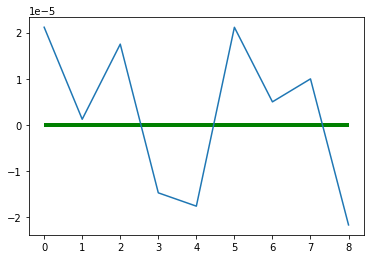

In [44]:
ax = dropResult['DiffWithSt'].plot()
ax.hlines(0, 0, 8, color='g',lw=4)

Marginal decrease in Performance even after dropping 270 variables, out of 495, we can reduce more,
This time reducing the step size

Looking at train loss and test loss we can see that reducing number of variables leads to less overfitting due to decrease in complexity

In [45]:
dropVarList2 = dropVars(vars_90,stLoss=valLoss,end=450,st=290,step=20)## 8 more models

In [46]:
dropResult2 = pd.DataFrame(dropVarList2).T.rename_axis('VariableDrops').reset_index()
dropResult2.columns = ['VariableDrops','trainLoss','testLoss','DiffWithSt']
dropResult2

,VariableDrops,trainLoss,testLoss,DiffWithSt
0,dropped_290,0.008051,0.016960,-0.000029
1,dropped_310,0.008259,0.017026,-0.000095
2,dropped_330,0.008492,0.017039,-0.000108
3,dropped_350,0.008775,0.017096,-0.000165
4,dropped_370,0.009147,0.017211,-0.000280
5,dropped_390,0.009619,0.017215,-0.000284
6,dropped_410,0.010274,0.017237,-0.000306
7,dropped_430,0.011056,0.017264,-0.000333


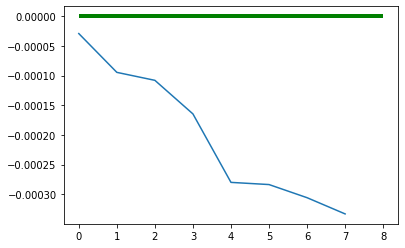

In [47]:
ax = dropResult2['DiffWithSt'].plot()
ax.hlines(0, 0, 8, color='g',lw=4)

Now we can see the clear drop, so from this step, we will drop up to 240 variables since there is no perf drop at this level,

To further reduce variables we will use correlations, adn drop correlated variables, 

In [48]:
corrVars = vars_90[270:][::-1] #dropping 240 vars, and sorting importance wise, most to least

len(corrVars)

226

In [49]:
corrM = np.abs(xTrain[corrVars].corr())### working with absolute correlations
corrM

,g-280,g-140,g-202,g-659,c-63,g-573,g-386,g-653,g-61,c-98,...,g-609,g-186,g-587,g-629,g-702,g-87,c-54,g-400,c-93,c-94
g-280,1.000000,0.404634,0.004110,0.100349,0.246456,0.127427,0.236207,0.137636,0.084422,0.243840,...,0.017336,0.161116,0.276532,0.245769,0.086189,0.222741,0.261400,0.024834,0.296697,0.288032
g-140,0.404634,1.000000,0.051667,0.454765,0.616351,0.142014,0.661661,0.261368,0.427394,0.591029,...,0.130393,0.528228,0.272609,0.645036,0.431011,0.300633,0.601226,0.405114,0.625284,0.611929
g-202,0.004110,0.051667,1.000000,0.097759,0.042053,0.031437,0.121548,0.049936,0.071900,0.163773,...,0.007337,0.029867,0.017984,0.136561,0.129286,0.208963,0.081914,0.009181,0.082584,0.104724
g-659,0.100349,0.454765,0.097759,1.000000,0.294197,0.030203,0.333078,0.159514,0.185337,0.243824,...,0.051288,0.289748,0.000624,0.312011,0.152386,0.189811,0.243346,0.236542,0.255064,0.264170
c-63,0.246456,0.616351,0.042053,0.294197,1.000000,0.018447,0.758814,0.278103,0.523874,0.819012,...,0.061056,0.713567,0.320842,0.751803,0.481840,0.271333,0.883760,0.542388,0.865735,0.894492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
g-87,0.222741,0.300633,0.208963,0.189811,0.271333,0.215913,0.188230,0.039990,0.083134,0.191933,...,0.022273,0.243812,0.206068,0.169288,0.111634,1.000000,0.247889,0.109345,0.274950,0.271194
c-54,0.261400,0.601226,0.081914,0.243346,0.883760,0.026074,0.752234,0.285187,0.542073,0.833677,...,0.043367,0.697572,0.350468,0.769831,0.468817,0.247889,1.000000,0.509209,0.869441,0.890666
g-400,0.024834,0.405114,0.009181,0.236542,0.542388,0.070907,0.449045,0.238624,0.209975,0.500912,...,0.028338,0.575485,0.044900,0.348739,0.394370,0.109345,0.509209,1.000000,0.522862,0.505578
c-93,0.296697,0.625284,0.082584,0.255064,0.865735,0.038032,0.758965,0.278014,0.514965,0.809979,...,0.046762,0.694274,0.333382,0.749618,0.505938,0.274950,0.869441,0.522862,1.000000,0.886620


In [55]:
def dropCorrelatedVars(corrM,cutoff):
    '''
    drop correlated vars having cor > cutoff, of the 2 variables with high corr
    will drop the one with the lower importance
    corrM corrlation matrix in order of least important to most imp variables
    cutoff Threshold
    '''
    
    dropVars=[]
    for i in range(corrM.shape[0]):
        for j in range(i+1, corrM.shape[0]):

            if corrM.iloc[i,j] >cutoff:
                #print(f' corr of {corrM.columns[i],corrM.columns[j]} is {corrM.iloc[i,j]}')
                dropVars.append(corrM.columns[j])
    return list(set(dropVars))            

In [57]:
results ={}
orgLoss = 0.016921     ### this is what we got at dropping 240 variables
for cutoff in np.arange(0.95,0.3,-0.05):
    droppedVars = dropCorrelatedVars(corrM,cutoff=cutoff)    
    remainingVars = list(set(corrVars).difference(set(droppedVars)))

    clf = MultiOutputClassifier(xgMod).fit(xTrain[remainingVars], yTrain)
    #get loss
    
    trainPreds = clf.predict_proba(xTrain[remainingVars])
    trainPreds = np.array(trainPreds)[:,:,1].T
    trainLoss = log_loss(np.ravel(yTrain), np.ravel(trainPreds))
    
    validPredsIn = clf.predict_proba(xValid[remainingVars])
    validPredsIn = np.array(validPredsIn)[:,:,1].T
    testLoss = log_loss(np.ravel(yValid), np.ravel(validPredsIn))
 
    results[f'CutOff_{np.round(cutoff,2)}'] = (len(droppedVars),trainLoss,testLoss,(testLoss-orgLoss))

   

In [58]:
corResults=pd.DataFrame(results).T.reset_index()
corResults.columns = ['cutOff','numDropped','TrainLoss','TestLoss','Diff']
corResults

,cutOff,numDropped,TrainLoss,TestLoss,Diff
0,CutOff_0.95,0.0,0.007890,0.016940,0.000019
1,CutOff_0.9,7.0,0.007944,0.016926,0.000005
2,CutOff_0.85,24.0,0.008117,0.017051,0.000130
3,CutOff_0.8,32.0,0.008253,0.017326,0.000405
4,CutOff_0.75,37.0,0.008295,0.017291,0.000370
5,CutOff_0.7,41.0,0.008338,0.017337,0.000416
6,CutOff_0.65,56.0,0.008519,0.017406,0.000485
7,CutOff_0.6,79.0,0.008864,0.017434,0.000513
8,CutOff_0.55,96.0,0.009190,0.017554,0.000633
9,CutOff_0.5,109.0,0.009515,0.017625,0.000704


<AxesSubplot:title={'center':'loss vs correlation cutOff'}>

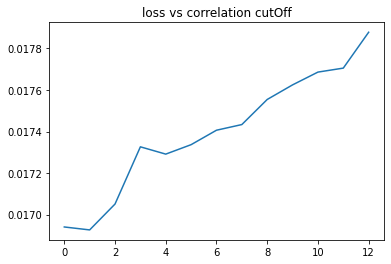

In [59]:
corResults['TestLoss'].plot(title='loss vs correlation cutOff')

We will drop correlated variables upto 0.9 cutoff, since there is decrease in performance after that level

In [60]:
droppedVars = dropCorrelatedVars(corrM,cutoff=0.9) ### saving list upto    
finVars =  set(corrVars).difference(set(droppedVars))
pd.DataFrame(finVars).to_csv('../dumps/finVars_1ModelXg.csv')
len(finVars)

219

In [5]:
finVars = pd.read_csv('../dumps/finVars_1ModelXg.csv')

In [11]:
finVars =list(finVars.iloc[:,1].values)

#### we need to run grid search on these vars

### We can cv over top 5 models picked.

In [10]:
def GridParamTune(gridParams,params,Drop=1,verbose=1):
    '''
    Xgboost Param tuning
    Author: Taran
    
    Given a params dictionary this function implements Grid and random search
    The cv object can be replaced for any other model
    
    Args - dTrain matrix,
            gridParams A parameters dictinary with candidate search space
            Drop Rate - for  Random search [0,1]
            verbose 0 0r 1 
            params  ---not to be tuned parameters
            EvalMetric  -- takes 1 eval metric
    Output
    Returns a df with results for each params
    Additional dependency itertools
    
    '''
    import itertools
    #paramers passed
    paramNames = list(gridParams.keys())
    
    results = []
    ### iterate over all combinations
    for row in itertools.product(*gridParams.values()):
        ### random search threshold
        if np.random.random(1)[0] > Drop:
            continue 
        
        # insert values into param dict
        for i in range(len(row)):
            params[paramNames[i]] = row[i]
        
        xgMod = XGBClassifier(**params,random_state=SEED)

        #get results 
        clf = MultiOutputClassifier(xgMod).fit(xTrain[finVars], yTrain)
        #get loss
    
        trainPreds = clf.predict_proba(xTrain[finVars])
        trainPreds = np.array(trainPreds)[:,:,1].T
        trainLoss = log_loss(np.ravel(yTrain), np.ravel(trainPreds))

        validPredsIn = clf.predict_proba(xValid[finVars])
        validPredsIn = np.array(validPredsIn)[:,:,1].T
        testLoss = log_loss(np.ravel(yValid), np.ravel(validPredsIn))


        overfit = ( (testLoss/trainLoss)-1)*100
        
        #unlist
        tempResults=[list(params.values())[1:],trainLoss,testLoss,overfit]      

        results.append(list(itertools.chain.from_iterable(i if isinstance(i, list) else [i] for i in tempResults)))
         
#     colNames=[paramNames,'trainLoss','testLoss','overfit']              
#     df = pd.DataFrame(results,columns=list(itertools.chain.from_iterable(i if isinstance(i, list) else [i] for i in colNames)))
                  
    return results


In [73]:

NumRows =xTrain.shape[0]
gridParams = {
   
    'max_depth' : [8,10],### making tree shallower by max leaves
    'eta' : [0.05],
    'colsample_bytree' : [0.4,0.7],
    'min_child_weight' : [int(NumRows*0.001),int(NumRows*0.003)],
    'gamma': [1,5],
    'max_leaves': [16,24], ## to constraint tree to be shallower,and deeper 
    'max_delta_step':[1,5]
}


params = {
     'tree_method':'gpu_hist',
    'grow_policy': 'lossguide',
    'objective':'binary:logistic',
     'n_estimators': 1000
}


In [63]:
params = {
     'tree_method':'gpu_hist',
    'grow_policy': 'lossguide',
    'objective':'binary:logistic',
     'n_estimators': 1000
}

In [15]:
%time paramResults=GridParamTune(gridParams=gridParams,params=params)


CPU times: user 6h 4min 55s, sys: 1min 27s, total: 6h 6min 22s
Wall time: 4h 39min 5s


In [17]:
paramResults

[['lossguide',
  'binary:logistic',
  1000,
  8,
  0.05,
  0.4,
  16,
  1,
  16,
  1,
  0.007773869885477753,
  0.016961420835653076,
  118.18503635285236],
 ['lossguide',
  'binary:logistic',
  1000,
  8,
  0.05,
  0.4,
  16,
  1,
  16,
  5,
  0.007759219058403552,
  0.0169508169857213,
  118.46034836924564],
 ['lossguide',
  'binary:logistic',
  1000,
  8,
  0.05,
  0.4,
  16,
  1,
  24,
  1,
  0.007775756257269503,
  0.016943530823206612,
  117.90203116727352],
 ['lossguide',
  'binary:logistic',
  1000,
  8,
  0.05,
  0.4,
  16,
  1,
  24,
  5,
  0.007758980498501979,
  0.016948938846716482,
  118.44285921312476],
 ['lossguide',
  'binary:logistic',
  1000,
  8,
  0.05,
  0.4,
  16,
  5,
  16,
  1,
  0.013371439502242979,
  0.016528031218714608,
  23.606970034468834],
 ['lossguide',
  'binary:logistic',
  1000,
  8,
  0.05,
  0.4,
  16,
  5,
  16,
  5,
  0.013344194550292288,
  0.01653065662621395,
  23.879013933080493],
 ['lossguide',
  'binary:logistic',
  1000,
  8,
  0.05,
  0.

In [18]:
import itertools

colNames=['growth','obj','rounds',list(gridParams.keys()),'trainLoss','testLoss','overfit']              
df = pd.DataFrame(paramResults,columns=list(itertools.chain.from_iterable(i if isinstance(i, list) else [i] for i in colNames)))
df

,growth,obj,rounds,max_depth,eta,colsample_bytree,min_child_weight,gamma,max_leaves,max_delta_step,trainLoss,testLoss,overfit
0,lossguide,binary:logistic,1000,8,0.05,0.4,16,1,16,1,0.007774,0.016961,118.185036
1,lossguide,binary:logistic,1000,8,0.05,0.4,16,1,16,5,0.007759,0.016951,118.460348
2,lossguide,binary:logistic,1000,8,0.05,0.4,16,1,24,1,0.007776,0.016944,117.902031
3,lossguide,binary:logistic,1000,8,0.05,0.4,16,1,24,5,0.007759,0.016949,118.442859
4,lossguide,binary:logistic,1000,8,0.05,0.4,16,5,16,1,0.013371,0.016528,23.606970
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,lossguide,binary:logistic,1000,10,0.05,0.7,50,1,24,5,0.014891,0.017832,19.746947
60,lossguide,binary:logistic,1000,10,0.05,0.7,50,5,16,1,0.016985,0.017766,4.594774
61,lossguide,binary:logistic,1000,10,0.05,0.7,50,5,16,5,0.016963,0.017755,4.673215
62,lossguide,binary:logistic,1000,10,0.05,0.7,50,5,24,1,0.016985,0.017766,4.594774


In [19]:
df.sort_values(['testLoss']).head(20)

,growth,obj,rounds,max_depth,eta,colsample_bytree,min_child_weight,gamma,max_leaves,max_delta_step,trainLoss,testLoss,overfit
38,lossguide,binary:logistic,1000,10,0.05,0.4,16,5,24,1,0.013361,0.016526,23.685212
36,lossguide,binary:logistic,1000,10,0.05,0.4,16,5,16,1,0.013357,0.016526,23.720892
4,lossguide,binary:logistic,1000,8,0.05,0.4,16,5,16,1,0.013371,0.016528,23.606970
6,lossguide,binary:logistic,1000,8,0.05,0.4,16,5,24,1,0.013371,0.016528,23.606970
39,lossguide,binary:logistic,1000,10,0.05,0.4,16,5,24,5,0.013346,0.016528,23.841135
37,lossguide,binary:logistic,1000,10,0.05,0.4,16,5,16,5,0.013346,0.016528,23.841135
7,lossguide,binary:logistic,1000,8,0.05,0.4,16,5,24,5,0.013347,0.016530,23.850222
20,lossguide,binary:logistic,1000,8,0.05,0.7,16,5,16,1,0.013246,0.016530,24.799478
5,lossguide,binary:logistic,1000,8,0.05,0.4,16,5,16,5,0.013344,0.016531,23.879014
22,lossguide,binary:logistic,1000,8,0.05,0.7,16,5,24,1,0.013240,0.016532,24.863955


In [20]:
df.sort_values(['overfit']).head(20)

,growth,obj,rounds,max_depth,eta,colsample_bytree,min_child_weight,gamma,max_leaves,max_delta_step,trainLoss,testLoss,overfit
46,lossguide,binary:logistic,1000,10,0.05,0.4,50,5,24,1,0.017050,0.017780,4.278975
44,lossguide,binary:logistic,1000,10,0.05,0.4,50,5,16,1,0.017050,0.017780,4.278975
12,lossguide,binary:logistic,1000,8,0.05,0.4,50,5,16,1,0.017050,0.017780,4.278975
14,lossguide,binary:logistic,1000,8,0.05,0.4,50,5,24,1,0.017050,0.017780,4.278975
47,lossguide,binary:logistic,1000,10,0.05,0.4,50,5,24,5,0.017028,0.017764,4.322075
45,lossguide,binary:logistic,1000,10,0.05,0.4,50,5,16,5,0.017028,0.017764,4.322075
15,lossguide,binary:logistic,1000,8,0.05,0.4,50,5,24,5,0.017028,0.017764,4.322075
13,lossguide,binary:logistic,1000,8,0.05,0.4,50,5,16,5,0.017028,0.017764,4.322075
60,lossguide,binary:logistic,1000,10,0.05,0.7,50,5,16,1,0.016985,0.017766,4.594774
62,lossguide,binary:logistic,1000,10,0.05,0.7,50,5,24,1,0.016985,0.017766,4.594774


In [21]:
### Tuning Gamma
NumRows =xTrain.shape[0]
gridParams = {
   
    'max_depth' : [10],### making tree shallower by max leaves
    'eta' : [0.05],
    'colsample_bytree' : [0.4],
    'min_child_weight' : [int(NumRows*0.001)],
    'gamma': [3,5,8],
    'max_leaves': [24], ## to constraint tree to be shallower,and deeper 
    'max_delta_step':[1],
     'n_estimators': [1000,1500,2000]
}


params = {
     'tree_method':'gpu_hist',
    'grow_policy': 'lossguide',
    'objective':'binary:logistic'
}

In [22]:
%time paramResults2=GridParamTune(gridParams=gridParams,params=params)

CPU times: user 1h 4min 31s, sys: 14.1 s, total: 1h 4min 45s
Wall time: 50min 48s


In [24]:
colNames=['obj','rounds',list(gridParams.keys()),'trainLoss','testLoss','overfit']              
df2 = pd.DataFrame(paramResults2,columns=list(itertools.chain.from_iterable(i if isinstance(i, list) else [i] for i in colNames)))
df2

,obj,rounds,max_depth,eta,colsample_bytree,min_child_weight,gamma,max_leaves,max_delta_step,n_estimators,trainLoss,testLoss,overfit
0,lossguide,binary:logistic,10,0.05,0.4,16,3,24,1,1000,0.011154,0.016524,48.152871
1,lossguide,binary:logistic,10,0.05,0.4,16,3,24,1,1500,0.011154,0.016524,48.152838
2,lossguide,binary:logistic,10,0.05,0.4,16,3,24,1,2000,0.011154,0.016524,48.152825
3,lossguide,binary:logistic,10,0.05,0.4,16,5,24,1,1000,0.013361,0.016526,23.685212
4,lossguide,binary:logistic,10,0.05,0.4,16,5,24,1,1500,0.013361,0.016526,23.685184
5,lossguide,binary:logistic,10,0.05,0.4,16,5,24,1,2000,0.013361,0.016526,23.685174
6,lossguide,binary:logistic,10,0.05,0.4,16,8,24,1,1000,0.015185,0.016680,9.846470
7,lossguide,binary:logistic,10,0.05,0.4,16,8,24,1,1500,0.015185,0.016680,9.846460
8,lossguide,binary:logistic,10,0.05,0.4,16,8,24,1,2000,0.015185,0.016680,9.846455


In [27]:
df2.sort_values(['testLoss']).head(20)

,obj,rounds,max_depth,eta,colsample_bytree,min_child_weight,gamma,max_leaves,max_delta_step,n_estimators,trainLoss,testLoss,overfit
0,lossguide,binary:logistic,10,0.05,0.4,16,3,24,1,1000,0.011154,0.016524,48.152871
1,lossguide,binary:logistic,10,0.05,0.4,16,3,24,1,1500,0.011154,0.016524,48.152838
2,lossguide,binary:logistic,10,0.05,0.4,16,3,24,1,2000,0.011154,0.016524,48.152825
3,lossguide,binary:logistic,10,0.05,0.4,16,5,24,1,1000,0.013361,0.016526,23.685212
4,lossguide,binary:logistic,10,0.05,0.4,16,5,24,1,1500,0.013361,0.016526,23.685184
5,lossguide,binary:logistic,10,0.05,0.4,16,5,24,1,2000,0.013361,0.016526,23.685174
6,lossguide,binary:logistic,10,0.05,0.4,16,8,24,1,1000,0.015185,0.016680,9.846470
7,lossguide,binary:logistic,10,0.05,0.4,16,8,24,1,1500,0.015185,0.016680,9.846460
8,lossguide,binary:logistic,10,0.05,0.4,16,8,24,1,2000,0.015185,0.016680,9.846455


In [28]:
df2.sort_values(['overfit']).head(20)

,obj,rounds,max_depth,eta,colsample_bytree,min_child_weight,gamma,max_leaves,max_delta_step,n_estimators,trainLoss,testLoss,overfit
8,lossguide,binary:logistic,10,0.05,0.4,16,8,24,1,2000,0.015185,0.016680,9.846455
7,lossguide,binary:logistic,10,0.05,0.4,16,8,24,1,1500,0.015185,0.016680,9.846460
6,lossguide,binary:logistic,10,0.05,0.4,16,8,24,1,1000,0.015185,0.016680,9.846470
5,lossguide,binary:logistic,10,0.05,0.4,16,5,24,1,2000,0.013361,0.016526,23.685174
4,lossguide,binary:logistic,10,0.05,0.4,16,5,24,1,1500,0.013361,0.016526,23.685184
3,lossguide,binary:logistic,10,0.05,0.4,16,5,24,1,1000,0.013361,0.016526,23.685212
2,lossguide,binary:logistic,10,0.05,0.4,16,3,24,1,2000,0.011154,0.016524,48.152825
1,lossguide,binary:logistic,10,0.05,0.4,16,3,24,1,1500,0.011154,0.016524,48.152838
0,lossguide,binary:logistic,10,0.05,0.4,16,3,24,1,1000,0.011154,0.016524,48.152871


### final model

##### CV

In [29]:
NumRows =xTrain.shape[0]


params = {
    'objective':'binary:logistic',
    #'num_class':2,
    'max_depth' : 10, # for gpu hist
    'eta' : 0.05,
    'colsample_bytree' : 0.4,
    'min_child_weight' : int(NumRows*0.001),
    'gamma': 5,
    'tree_method':'gpu_hist',
    'grow_policy': 'lossguide',
    'max_leaves': 24, ## to constraint tree to be shallower
    'n_estimators': 1000,
    'max_delta_step':1
    
}


xgMod = XGBClassifier(**params,random_state=SEED)

In [30]:
%%time

trainLosses = []
validLosses = []
validPreds = []
featImp = []
for i in range(5):
    
    trainIds= xAll['sig_id'].sample(frac=0.7,random_state=(SEED +100*i + 10*i +i ))
    xTrain = xAll[xAll['sig_id'].isin(trainIds)]
    yTrain = yAll[yAll['sig_id'].isin(trainIds)]
    xValid = xAll[~xAll['sig_id'].isin(trainIds)]
    yValid = yAll[~yAll['sig_id'].isin(trainIds)]
 
    xTrain=xTrain.drop(idList,axis=1)
    xValid=xValid.drop(idList,axis=1)
    yTrain=yTrain.drop(idList,axis=1)
    yValid=yValid.drop(idList,axis=1)
                                    
                                    
    #fit model
    clf = MultiOutputClassifier(xgMod).fit(xTrain[finVars], yTrain)
    #get loss
    trainPreds = clf.predict_proba(xTrain[finVars])
    trainPreds = np.array(trainPreds)[:,:,1].T
    trainLoss = log_loss(np.ravel(yTrain), np.ravel(trainPreds))
    trainLosses.append(trainLoss)
    
    validPredsIn = clf.predict_proba(xValid[finVars])
    validPredsIn = np.array(validPredsIn)[:,:,1].T
    validPreds.append(validPredsIn)
    valLoss = log_loss(np.ravel(yValid), np.ravel(validPredsIn))
    validLosses.append(valLoss)
    #get importances
    InnerImp = [] 
    #multioutput importances
    for model in clf.estimators_:
        InnerImp.append(model.feature_importances_)
    featImp.append(np.nanmean(InnerImp, axis=0) )   
        
validLosses

/home/taran/depot/Projects/kaggleDev/venv/lib/python3.6/site-packages/xgboost/sklearn.py:695: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/taran/depot/Projects/kaggleDev/venv/lib/python3.6/site-packages/xgboost/sklearn.py:695: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/taran/depot/Projects/kaggleDev/venv/lib/python3.6/site-packages/xgboost/sklearn.py:695: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/taran/depot/Projects/kaggleDev/venv/lib/python3.6/site-packages/xgboost/sklearn.py:695: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/taran/depot/Projects/kaggleDev/venv/lib/python3.6/site-packages/xgboost/sklearn.py:695: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()


CPU times: user 26min 4s, sys: 6.26 s, total: 26min 10s
Wall time: 19min 49s


[0.01652559644695702,
 0.016779702766843662,
 0.016569341983876718,
 0.016487815920673277,
 0.016571669349384307]

In [31]:
trainLosses 


[0.013361012319180098,
 0.013277220043316083,
 0.013329097282684398,
 0.013369980487311903,
 0.01329110373426141]

In [73]:


predsDf = pd.DataFrame(validPreds[2],columns=yValid.columns )

In [82]:
validPreds

[array([[0.00103151, 0.00095975, 0.00095558, ..., 0.00125918, 0.0011878 ,
         0.00098684],
        [0.00093006, 0.00095975, 0.00095558, ..., 0.00104515, 0.00119152,
         0.00098684],
        [0.00093006, 0.00095975, 0.00095558, ..., 0.00108389, 0.00096257,
         0.00098684],
        ...,
        [0.00093006, 0.00095975, 0.00095558, ..., 0.00108389, 0.00344124,
         0.00132718],
        [0.00093006, 0.00095975, 0.00095558, ..., 0.00104515, 0.00144277,
         0.00098684],
        [0.00099724, 0.00095975, 0.00095558, ..., 0.00121418, 0.00160305,
         0.00132718]], dtype=float32),
 array([[0.00115268, 0.0009598 , 0.00096072, ..., 0.00159167, 0.00158951,
         0.00130504],
        [0.00089855, 0.0009598 , 0.00096072, ..., 0.00136413, 0.00206857,
         0.00144281],
        [0.00086643, 0.0009598 , 0.00096072, ..., 0.00106278, 0.01253433,
         0.00109141],
        ...,
        [0.00099025, 0.0009598 , 0.00096072, ..., 0.00115178, 0.00169817,
         0.00135561

In [75]:
predsDf.describe()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
count,7144.000000,7144.00000,7144.000000,7144.000000,7144.000000,7144.000000,7144.000000,7144.000000,7144.000000,7144.000000,...,7144.00000,7144.000000,7144.000000,7144.000000,7144.000000,7144.000000,7144.000000,7144.000000,7144.000000,7144.000000
mean,0.000960,0.00096,0.000961,0.008281,0.013029,0.003252,0.002082,0.003702,0.000958,0.010617,...,0.00096,0.000960,0.002109,0.013153,0.002771,0.000951,0.006955,0.000958,0.001509,0.001258
std,0.000135,0.00000,0.000000,0.006095,0.009752,0.001974,0.001156,0.002589,0.000000,0.010552,...,0.00000,0.000056,0.000593,0.085755,0.001963,0.000000,0.027501,0.000000,0.000896,0.000077
min,0.000777,0.00096,0.000961,0.000603,0.000980,0.000693,0.000516,0.000531,0.000958,0.000473,...,0.00096,0.000906,0.000974,0.000407,0.000427,0.000951,0.000813,0.000958,0.000554,0.001180
25%,0.000839,0.00096,0.000961,0.004351,0.006415,0.001850,0.001246,0.001968,0.000958,0.004550,...,0.00096,0.000906,0.001660,0.001463,0.001515,0.000951,0.001906,0.000958,0.000900,0.001180
50%,0.000934,0.00096,0.000961,0.007022,0.011076,0.002792,0.001809,0.003077,0.000958,0.007920,...,0.00096,0.000906,0.002019,0.002199,0.002224,0.000951,0.002676,0.000958,0.001242,0.001277
75%,0.001050,0.00096,0.000961,0.010643,0.017356,0.004121,0.002627,0.004663,0.000958,0.013295,...,0.00096,0.001017,0.002462,0.003630,0.003386,0.000951,0.004257,0.000958,0.001786,0.001336
max,0.001411,0.00096,0.000961,0.064062,0.108557,0.022759,0.008983,0.026763,0.000958,0.149884,...,0.00096,0.001017,0.005256,0.979829,0.024575,0.000951,0.803533,0.000958,0.008051,0.001336


In [76]:

def getLogLoss(y,yhat):
    '''
    logloss
    '''
    assert len(y)==len(yhat)
    eps= 1e-15
    
    yhat= np.clip(yhat,eps,1-eps)
    return -1*np.mean(y*np.log(yhat) + (1-y)*np.log(1-yhat))

In [77]:
resultsDf = pd.DataFrame(yValid.columns,columns=['varname'])
resultsDf['logloss'] = resultsDf['varname'].map(lambda var: getLogLoss(yValid[var].values,predsDf[var].values) )

In [78]:
resultsDf.sort_values(by=['logloss'],ascending=False, inplace=True)

In [79]:
resultsDf['valCount'] = resultsDf['varname'].map(lambda var: yValid[var].sum()) 
resultsDf['Prop'] = resultsDf['varname'].map(lambda var: yValid[var].sum()/(yValid.shape[0]))

In [80]:
resultsDf.head(50)

,varname,logloss,valCount,Prop
163,proteasome_inhibitor,0.347513,213,0.029815
136,nfkb_inhibitor,0.305695,253,0.035414
199,tubulin_inhibitor,0.112584,105,0.014698
63,cdk_inhibitor,0.111435,96,0.013438
77,dna_inhibitor,0.103509,142,0.019877
96,glucocorticoid_receptor_agonist,0.100165,87,0.012178
80,egfr_inhibitor,0.095581,95,0.013298
71,cyclooxygenase_inhibitor,0.095554,129,0.018057
79,dopamine_receptor_antagonist,0.093576,124,0.017357
177,serotonin_receptor_antagonist,0.092815,124,0.017357


In [81]:
resultsDf['logloss'].mean()

0.024560134722327678

In [27]:
resultsDf.tail(50)

,varname,logloss,valCount,Prop
106,histone_lysine_demethylase_inhibitor,0.006085,6,0.000840
92,fungal_squalene_epoxidase_inhibitor,0.005911,5,0.000700
97,glutamate_inhibitor,0.005859,5,0.000700
87,fatty_acid_receptor_agonist,0.005749,5,0.000700
1,11-beta-hsd1_inhibitor,0.005662,5,0.000700
113,imidazoline_receptor_agonist,0.005342,4,0.000560
140,nitric_oxide_synthase_inhibitor,0.005115,4,0.000560
37,atr_kinase_inhibitor,0.005048,5,0.000700
50,beta_amyloid_inhibitor,0.005023,4,0.000560
138,nitric_oxide_donor,0.004947,4,0.000560


In [28]:
predsDf['cyclooxygenase_inhibitor'].describe()

count    7144.000000
mean        0.004247
std         0.007690
min         0.000010
25%         0.000827
50%         0.002025
75%         0.004691
max         0.160498
Name: cyclooxygenase_inhibitor, dtype: float64

In [29]:
yValid['cyclooxygenase_inhibitor'].describe()

count    7144.000000
mean        0.019317
std         0.137646
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: cyclooxygenase_inhibitor, dtype: float64

In [44]:
predsTemp = pd.DataFrame(yValid['cyclooxygenase_inhibitor']).reset_index(drop=True)

In [45]:
predsTemp['Predictions'] =  predsDf['cyclooxygenase_inhibitor']

In [46]:
predsTemp.head()

,cyclooxygenase_inhibitor,Predictions
0,0,0.006694
1,0,0.002841
2,0,0.015550
3,0,0.001458
4,0,0.001156


In [47]:
predsTemp.sort_values(by=['Predictions'],ascending=False)

,cyclooxygenase_inhibitor,Predictions
6996,1,0.160498
6316,0,0.128508
1333,0,0.113263
7019,0,0.108153
2453,0,0.107008
...,...,...
3238,0,0.000018
4029,0,0.000017
1929,0,0.000016
6493,0,0.000014


In [78]:
predsTemp.sort_values(by=['cyclooxygenase_inhibitor'],ascending=False).head(20)

,cyclooxygenase_inhibitor,Predictions,zeros
2297,1,0.001864,0.04
6545,1,0.006366,0.04
3027,1,0.003437,0.04
6996,1,0.160498,0.04
6335,1,0.000741,0.04
1459,1,0.001472,0.04
4386,1,0.012031,0.04
3454,1,0.016020,0.04
6090,1,0.006857,0.04
3451,1,0.004214,0.04


In [43]:
predsDf['cyclooxygenase_inhibitor'].describe()

count    7144.000000
mean        0.004247
std         0.007690
min         0.000010
25%         0.000827
50%         0.002025
75%         0.004691
max         0.160498
Name: cyclooxygenase_inhibitor, dtype: float64

In [52]:
getLogLoss(predsTemp['cyclooxygenase_inhibitor'],predsTemp['Predictions'])

0.10715562620476837

In [74]:
predsTemp['zeros']= 0.04

getLogLoss(predsTemp['cyclooxygenase_inhibitor'],predsTemp['zeros'])

0.10221217209416565

In [63]:
getLogLoss(predsTemp['cyclooxygenase_inhibitor'],predsTemp['zeros'])

0.13441765591218102

In [75]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [77]:
getLogLoss(predsTemp['cyclooxygenase_inhibitor'],predsTemp['Predictions'])

0.10715562620476837

In [83]:
allPreds = validPreds[0]/5
for i in range(1,5):
    allPreds+=validPreds[i]/5


In [84]:
log_loss(np.ravel(yValid), np.ravel(allPreds))

0.018709705955952918

In [85]:
!ls ../Data

lish-moa.zip	       test_features.csv   train_targets_nonscored.csv
sample_submission.csv  train_features.csv  train_targets_scored.csv


In [86]:
xTest = pd.read_csv('../Data/test_features.csv')

In [97]:
xTest = PreProcessX(xTest)

In [98]:
testPredsIn = clf.predict_proba(xTest[finVars])

In [99]:
testPredsIn[0].shape

(3982, 2)

In [100]:
testPredsIn[0][0,0]

0.999045

In [101]:
np.array(testPredsIn)[:,:,1].T.shape

(3982, 206)

In [94]:
sub = pd.read_csv('../Data/sample_submission.csv')

In [103]:
sub[yValid.columns] = np.array(testPredsIn)[:,:,1].T

In [104]:
sub.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.000955,0.000845,0.000961,0.010790,0.013946,0.005172,0.004011,0.006444,0.000958,...,0.000936,0.001072,0.001932,0.001563,0.002130,0.000936,0.002820,0.001030,0.002520,0.001139
1,id_001897cda,0.000955,0.000845,0.000961,0.001523,0.005387,0.004012,0.001121,0.002132,0.000958,...,0.000936,0.001195,0.001554,0.001973,0.006544,0.000936,0.005954,0.000925,0.002713,0.001139
2,id_002429b5b,0.000955,0.000845,0.000961,0.010769,0.004309,0.002344,0.001036,0.004060,0.000958,...,0.000936,0.001072,0.002231,0.003542,0.000970,0.000936,0.001411,0.000925,0.004128,0.001185
3,id_00276f245,0.000955,0.001016,0.000961,0.002953,0.010180,0.005725,0.001361,0.012388,0.000958,...,0.000936,0.001171,0.002597,0.010924,0.002643,0.000936,0.001882,0.001030,0.003467,0.001185
4,id_0027f1083,0.000955,0.000845,0.000961,0.010439,0.005950,0.001218,0.002743,0.002373,0.000958,...,0.000936,0.001072,0.003120,0.001946,0.000821,0.000936,0.001116,0.001030,0.000506,0.001097


In [109]:
finVars

['g-484',
 'g-202',
 'g-260',
 'g-471',
 'g-364',
 'c-45',
 'c-86',
 'c-40',
 'g-717',
 'g-376',
 'g-565',
 'g-3',
 'g-662',
 'g-692',
 'g-288',
 'g-500',
 'g-673',
 'g-280',
 'g-261',
 'g-285',
 'g-243',
 'g-40',
 'g-10',
 'g-746',
 'g-59',
 'g-264',
 'g-36',
 'c-58',
 'g-144',
 'g-758',
 'g-516',
 'g-132',
 'g-400',
 'g-485',
 'g-512',
 'g-61',
 'g-498',
 'c-61',
 'g-416',
 'c-20',
 'g-759',
 'g-91',
 'g-604',
 'g-463',
 'cp_type',
 'g-689',
 'g-134',
 'g-408',
 'g-587',
 'g-14',
 'g-158',
 'g-140',
 'g-574',
 'g-162',
 'g-386',
 'g-43',
 'g-201',
 'c-68',
 'g-702',
 'g-539',
 'g-173',
 'g-653',
 'c-90',
 'g-578',
 'g-22',
 'g-392',
 'g-541',
 'c-63',
 'g-296',
 'g-630',
 'g-339',
 'g-234',
 'g-627',
 'g-203',
 'g-310',
 'g-85',
 'g-700',
 'g-343',
 'g-38',
 'c-0',
 'c-35',
 'c-92',
 'c-89',
 'g-136',
 'g-79',
 'c-7',
 'g-210',
 'g-750',
 'c-24',
 'g-94',
 'g-699',
 'g-327',
 'g-474',
 'g-491',
 'g-613',
 'g-575',
 'g-567',
 'g-577',
 'c-93',
 'g-369',
 'c-85',
 'g-90',
 'g-486',
 'g

In [110]:
len(finVars)

219